# Summary Statistics of Entire Dataset

In [271]:
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sqlalchemy as sa
from sqlalchemy import text

In [272]:
# find the current working directory
import os
import IPython

notebook_path = IPython.get_ipython().getoutput('pwd')[0]

data_dir = os.path.join(notebook_path, '..', 'data')

if not os.path.exists(data_dir):
    print(f'Creating directory: {data_dir}')
    os.makedirs(data_dir)

In [273]:
sns.set_style("ticks")

DEFAULT_COLOR = sns.color_palette("husl", 9)[6]

In [274]:
from datetime import datetime

date = datetime.now().strftime("%Y-%m-%d")

# create dir for figures
figures_dir = os.path.join(notebook_path, "..", "figures", "analysis_2", date)

if not os.path.exists(figures_dir):
    print(f"Creating directory: {figures_dir}")
os.makedirs(figures_dir)

Creating directory: /Users/ac4294/dev/2024/cpvt_database_analysis/notebooks/../figures/analysis_2/2024-07-10


In [275]:
# read db connection from .env file
from helpers.settings import get_settings

settings = get_settings()

In [276]:
engine = sa.create_engine(settings.postgresql_dsn.__str__())

In [277]:
with engine.connect() as conn:
    res = conn.execute(
        text(
            """
    SELECT COUNT(individual_id) AS num_patients
    FROM individual
    """
        )
    ).scalars().all()
    print(f"Number of patients: {res[0]}")

    res = conn.execute(
        text(
            """
            SELECT COUNT(variant_id) AS num_variants
            FROM variant_view_mv v
            WHERE provenance @> jsonb_build_array(jsonb_build_object('dataset_id', 2))
            """
        )
    ).scalars().all()

    print(f"Number of variants: {res[0]}")

Number of patients: 1347
Number of variants: 392


In [278]:
# get number of male / female patients
individuals_mv = pd.read_sql(
    """
    SELECT i.individual_id, s.value AS sex
    FROM individual i
    JOIN individual_sex s
    ON i.individual_sex_id = s.individual_sex_id
    JOIN individual_condition ic
    ON i.individual_id = ic.individual_id
    WHERE ic.has_condition = true
    AND ic.condition_id IN (
        SELECT condition_id
        FROM condition
        WHERE condition = 'Catecholaminergic polymorphic ventricular tachycardia 1'
    )
    ORDER BY i.individual_id
    """
    , engine)
individuals_mv.head()

,individual_id,sex
0,2,female
1,3,male
2,4,female
3,5,male
4,6,female


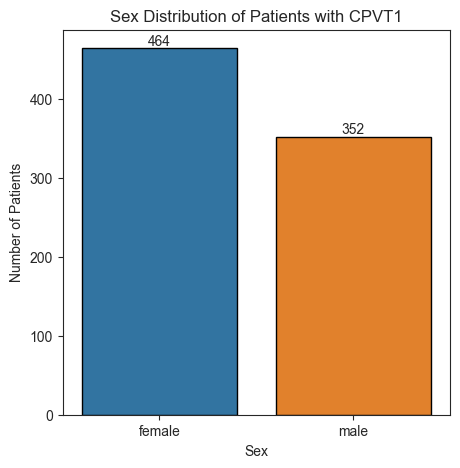

In [279]:
plt.figure(figsize=(5, 5))

ax = sns.countplot(data=individuals_mv,
                   x="sex",
                   hue="sex",
                   legend=False,
                   edgecolor="black",
                   )

plt.xlabel("Sex")
plt.ylabel("Number of Patients")
plt.title("Sex Distribution of Patients with CPVT1")

# Iterate over the bars
for bar in ax.patches:
    # Use ax.text() to add text over the bars
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            f'{bar.get_height():.0f}',
            ha='center', va='bottom')

for fmt in ["png", "pdf", "svg"]:
    plt.savefig(
        os.path.join(figures_dir, 'sex_distribution_cpvt1.' + fmt), dpi=300)

plt.show()

In [280]:
# plot primary diagnosis for each individual
prim_diagnosis = pd.read_sql(
    """
    SELECT c.condition, COUNT(ic.individual_id) AS num_patients
    FROM individual_condition ic
    JOIN condition c
    ON c.condition_id = ic.condition_id
    WHERE primary_diagnosis = true
    AND condition <> 'Substance use disorder'
    GROUP BY c.condition
    ORDER BY num_patients DESC
    """
    , engine)
prim_diagnosis.head()

,condition,num_patients
0,Catecholaminergic polymorphic ventricular tach...,968
1,Catecholaminergic polymorphic ventricular tach...,132
2,Long QT syndrome,45
3,Left ventricular non-compaction,18
4,Arrhythmogenic right ventricular cardiomyopathy,18


In [281]:
prim_diagnosis

,condition,num_patients
0,Catecholaminergic polymorphic ventricular tach...,968
1,Catecholaminergic polymorphic ventricular tach...,132
2,Long QT syndrome,45
3,Left ventricular non-compaction,18
4,Arrhythmogenic right ventricular cardiomyopathy,18
5,Short-coupled variant of torsade de pointes,15
6,Sudden infant death syndrome,13
7,Hyperglycemia,7
8,Other,7
9,Hypoplastic left heart syndrome,5


In [282]:

pd.read_sql("""
SELECT c.condition, cs.synonym
FROM condition c
LEFT JOIN condition_synonym cs
ON c.condition_id = cs.condition_id
WHERE c.condition = 'Short-coupled variant of torsade de pointes'
""", engine)

,condition,synonym
0,Short-coupled variant of torsade de pointes,scTdP


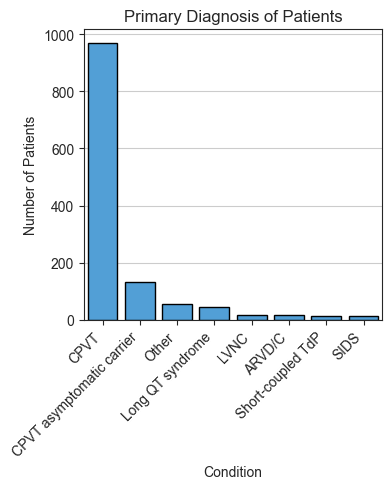

In [283]:
# group everything with less than 10 patients into "Other"
prim_diagnosis2 = prim_diagnosis.copy()
prim_diagnosis2.loc[
    prim_diagnosis["num_patients"] < 10, "condition"] = "Other"
prim_diagnosis2 = prim_diagnosis2.groupby("condition").sum().reset_index()
prim_diagnosis2.sort_values("num_patients", ascending=False, inplace=True)

shorter_names_map = {
    "Catecholaminergic polymorphic ventricular tachycardia 1": "CPVT",
    "Catecholaminergic polymorphic ventricular tachycardia 1 asymptomatic carrier": "CPVT asymptomatic carrier",
    "Arrhythmogenic right ventricular cardiomyopathy": "ARVD/C",
    "Short-coupled variant of torsade de pointes": "Short-coupled TdP",
    "Left ventricular non-compaction": "LVNC",
    "Sudden infant death syndrome": "SIDS",
    "Hypoplastic left heart syndrome": "HLHS",
}

# replace with shorter names
prim_diagnosis2["condition"] = prim_diagnosis2["condition"].replace(
    shorter_names_map)

plt.figure(figsize=(4, 5))
sns.barplot(prim_diagnosis2, x="condition", y="num_patients",
            color=DEFAULT_COLOR, edgecolor="black", )

plt.xticks(rotation=45, ha="right")

plt.xlabel("Condition")
plt.ylabel("Number of Patients")
plt.title("Primary Diagnosis of Patients")

plt.tight_layout()
plt.grid(axis="y")

for fmt in ["png", "pdf", "svg"]:
    plt.savefig(
        os.path.join(figures_dir, f"primary_diagnosis.{fmt}"), dpi=300
    )

plt.show()

In [284]:
conditions_to_graph = {
    "Exercise/stress induced polymorphic ventricular tachycardia": "Exercise-induced polymorphic VT",
    "Syncope exercise/stress induced": "Exercise-induced syncope",
    "Exercise/stress induced sudden cardiac arrest": "Exercise-induced Sudden Cardiac Arrest",
    "Baseline/resting electrocardiogram abnormality": "Abnormal ECG at rest",
}

individual_condition_graph = pd.read_sql(
    f"""
    SELECT
    c.condition,
    ic.has_condition,
    COUNT(ic.individual_id) AS num_patients
    FROM individual_condition ic
    JOIN condition c
    ON c.condition_id = ic.condition_id
    WHERE c.condition IN {tuple(conditions_to_graph)}
    AND ic.has_condition IS NOT NULL
    AND ic.individual_id IN (
        SELECT individual_id
        FROM individual_condition ic2
        JOIN condition c2
        ON c2.condition_id = ic2.condition_id
        WHERE c2.condition = 'Catecholaminergic polymorphic ventricular tachycardia 1'
        AND ic2.has_condition = true
    )   
    GROUP BY c.condition, ic.has_condition
    ORDER BY c.condition, ic.has_condition
    """, engine)
individual_condition_graph

,condition,has_condition,num_patients
0,Baseline/resting electrocardiogram abnormality,False,388
1,Baseline/resting electrocardiogram abnormality,True,77
2,Exercise/stress induced polymorphic ventricula...,False,7
3,Exercise/stress induced polymorphic ventricula...,True,316
4,Exercise/stress induced sudden cardiac arrest,False,16
5,Exercise/stress induced sudden cardiac arrest,True,97
6,Syncope exercise/stress induced,False,9
7,Syncope exercise/stress induced,True,262


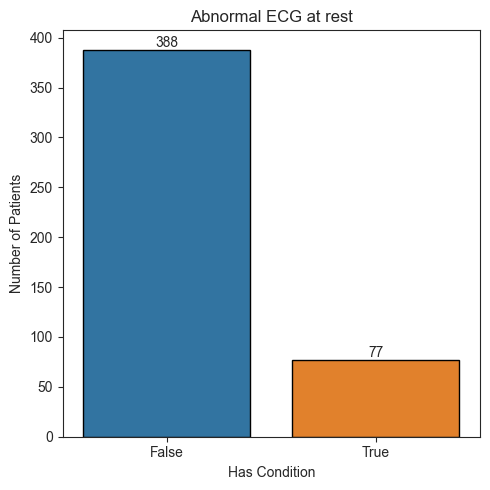

In [285]:
for condition, title in conditions_to_graph.items():
    condition_data = individual_condition_graph[
        individual_condition_graph["condition"] == condition
        ]

plt.figure(figsize=(5, 5))
ax = sns.barplot(
    data=condition_data,
    x="has_condition",
    y="num_patients",
    hue="has_condition",
    legend=False,
    edgecolor="black",
)

# Iterate over the bars
for bar in ax.patches:
    # Use ax.text() to add text over the bars
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            f'{bar.get_height():.0f}',
            ha='center', va='bottom')

plt.title(title)
plt.xlabel("Has Condition")
plt.ylabel("Number of Patients")

plt.tight_layout()

for fmt in ["png", "pdf", "svg"]:
    plt.savefig(
        os.path.join(figures_dir, f"{title}.{fmt}"), dpi=300
    )

plt.show()



In [286]:
# inheritance pattern of CPVT1
inheritance = pd.read_sql("""
SELECT vi.variant_inheritance, COUNT(i.individual_id) AS num_patients
FROM individual i 
JOIN individual_variant iv
ON i.individual_id = iv.individual_id
JOIN variant_inheritance vi
ON iv.variant_inheritance_id = vi.variant_inheritance_id
WHERE i.individual_id IN (
    SELECT individual_id
    FROM cpvt_patients_v
)
GROUP BY vi.variant_inheritance 
ORDER BY num_patients DESC
""", engine)
inheritance

,variant_inheritance,num_patients
0,inherited,186
1,spontaneous,88


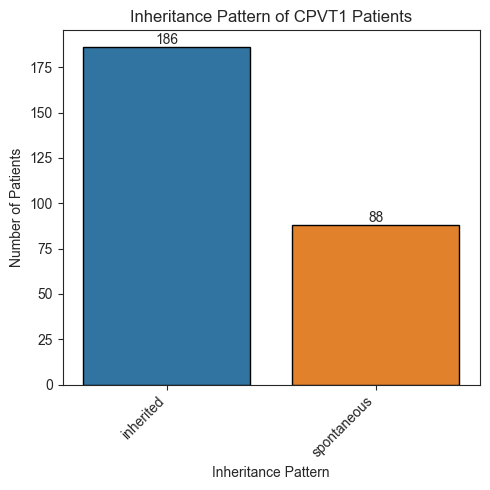

In [287]:
plt.figure(figsize=(5, 5))

ax = sns.barplot(data=inheritance,
                 x="variant_inheritance",
                 y="num_patients",
                 hue="variant_inheritance",
                 legend=False,
                 edgecolor="black",
                 )
plt.xticks(rotation=45, ha="right")
plt.xlabel("Inheritance Pattern")
plt.ylabel("Number of Patients")
plt.title("Inheritance Pattern of CPVT1 Patients")

# Iterate over the bars
for bar in ax.patches:
    # Use ax.text() to add text over the bars
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            f'{bar.get_height():.0f}',
            ha='center', va='bottom')

plt.tight_layout()
for fmt in ["png", "pdf", "svg"]:
    plt.savefig(
        os.path.join(figures_dir, 'inheritance_pattern_cpvt1.' + fmt), dpi=300)

plt.show()


In [288]:
family_history_scd = pd.read_sql("""
SELECT individual_id,
bool_or(has_family_history) AS has_family_history
FROM (
SELECT fhr.individual_id,
        CASE WHEN num_family_members >= 1 THEN TRUE
        WHEN has_condition = TRUE THEN TRUE
        WHEN has_condition = FALSE THEN FALSE
        WHEN num_family_members = 0 THEN FALSE
        ELSE
            NULL
        END AS has_family_history
FROM family_history_record fhr
JOIN condition c
ON fhr.condition_id = c.condition_id
LEFT JOIN family_member_history fmh
ON fhr.family_history_record_id = fmh.family_history_record_id
WHERE c.condition = 'Sudden cardiac death'
AND fhr.individual_id IN (
    SELECT individual_id
    FROM individual_condition ic
    JOIN condition c2
    ON ic.condition_id = c2.condition_id
    WHERE c2.condition = 'Catecholaminergic polymorphic ventricular tachycardia 1'
    AND ic.has_condition = true
)
) AS subquery
WHERE has_family_history IS NOT NULL
GROUP BY individual_id
""", engine)
family_history_scd.head()

,individual_id,has_family_history
0,1,True
1,4,False
2,10,True
3,11,True
4,13,False


In [289]:
family_history_scd["has_family_history"].value_counts(dropna=False)

has_family_history
True     349
False    144
Name: count, dtype: int64

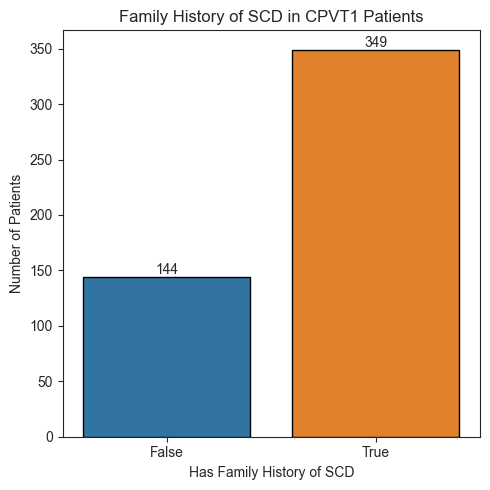

In [290]:
plt.figure(figsize=(5, 5))

ax = sns.countplot(data=family_history_scd,
                   x="has_family_history",
                   hue="has_family_history",
                   legend=False,
                   edgecolor="black",
                   )

plt.xlabel("Has Family History of SCD")
plt.ylabel("Number of Patients")
plt.title("Family History of SCD in CPVT1 Patients")

# Iterate over the bars
for bar in ax.patches:
    # Use ax.text() to add text over the bars
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            f'{bar.get_height():.0f}',
            ha='center', va='bottom')

plt.tight_layout()
for fmt in ["png", "pdf", "svg"]:
    plt.savefig(
        os.path.join(figures_dir, 'family_history_scd.' + fmt), dpi=300)

plt.show()

In [291]:
# treatments for patients using Beta Blockers
beta_blockers = pd.read_sql("""
SELECT t.treatment_name, COUNT(tr.patient_id) AS num_patients
FROM treatment_record tr
JOIN treatment t
ON tr.treatment_id = t.treatment_id
WHERE tr.patient_id IN (
    SELECT individual_id
    FROM cpvt_patients_v
) AND
tr.treatment_taken = TRUE AND 
tr.patient_id IN (
    SELECT tr.patient_id
    FROM treatment_record tr
    JOIN treatment t
    ON tr.treatment_id = t.treatment_id
    WHERE t.treatment_name = 'Beta blocker'
    AND tr.treatment_taken = TRUE
)
GROUP BY t.treatment_name 
ORDER BY num_patients DESC
""", engine)
# drop the row "Beta blocker" as it is redundant
beta_blockers = beta_blockers[beta_blockers["treatment_name"] != "Beta blocker"]
beta_blockers

,treatment_name,num_patients
1,Flecainide,117
2,Implantable cardioverter-defibrillator,116
3,Verapamil,28
4,Left cardiac sympathetic denervation,22
5,Catheter ablation,10
6,Enalapril,2


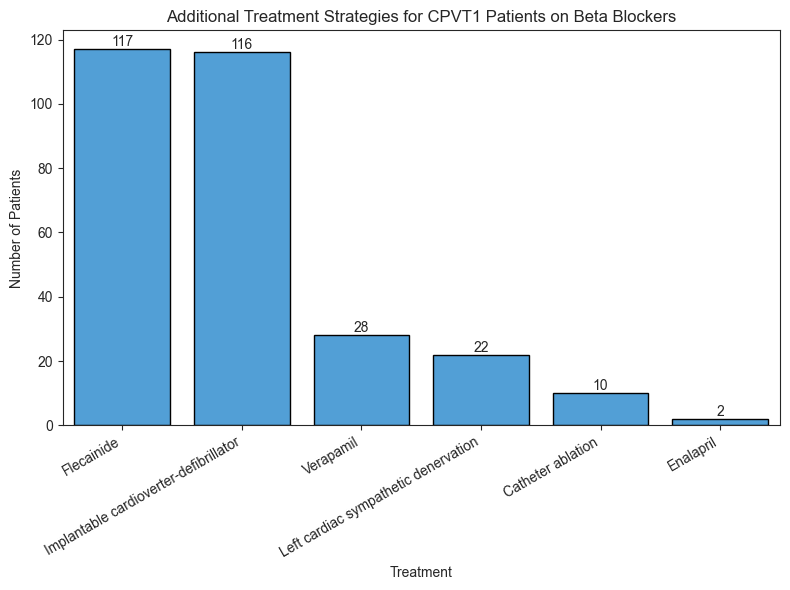

In [292]:
plt.figure(figsize=(8, 6))

ax = sns.barplot(data=beta_blockers, x="treatment_name", y="num_patients",
                 color=DEFAULT_COLOR, edgecolor="black", )

plt.xticks(rotation=30, ha="right")

plt.xlabel("Treatment")
plt.ylabel("Number of Patients")
plt.title("Additional Treatment Strategies for CPVT1 Patients on Beta Blockers")

# Iterate over the bars
for bar in ax.patches:
    # Use ax.text() to add text over the bars
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            f'{bar.get_height():.0f}',
            ha='center', va='bottom')

plt.tight_layout()

for fmt in ["png", "pdf", "svg"]:
    plt.savefig(
        os.path.join(figures_dir, 'treatment_strategies_cpvt1.' + fmt), dpi=300)

plt.show()


In [351]:
NUM_TOP_VARIANTS = 5

# mutation specific strageties for most common mutations
mutation_strategies = pd.read_sql(f"""
SELECT sv.p_posedit_str, treatment_name, COUNT(tr.patient_id) AS num_patients
FROM treatment_record tr
JOIN treatment t
ON tr.treatment_id = t.treatment_id
JOIN individual_variant iv
ON tr.patient_id = iv.individual_id
JOIN variant v
ON iv.variant_id = v.variant_id
JOIN sequence_variant sv
ON sv.sequence_variant_id = v.sequence_variant_id
WHERE 1 = 1 
AND tr.patient_id IN (
-- ONLY CPVT1 patients
    SELECT individual_id
    FROM cpvt_patients_v
) 
AND tr.patient_id IN (
-- ONLY PATIENTS WITH TOP 5 VARIANTS BY NUMBER OF INDIVIDUALS
    SELECT iv.individual_id
    FROM individual_variant iv
    JOIN variant v 
    ON iv.variant_id = v.variant_id
    WHERE v.variant_id IN (
        SELECT v2.variant_id 
        FROM variant_num_individuals_v v2 
        ORDER BY v2.num_individuals DESC 
        LIMIT {NUM_TOP_VARIANTS}
    )
) 
AND tr.patient_id IN (
-- ONLY PATIENTS WHO ARE TAKING BETA BLOCKERS
    SELECT tr.patient_id
    FROM treatment_record tr
    JOIN treatment t
    ON tr.treatment_id = t.treatment_id
    WHERE t.treatment_name = 'Beta blocker'
    AND tr.treatment_taken = TRUE
)
AND tr.treatment_taken = TRUE
GROUP BY sv.p_posedit_str, treatment_name
ORDER BY sv.p_posedit_str, treatment_name
""", engine)
# drop the row "Beta blocker" as it is redundant
# mutation_strategies = mutation_strategies[
#     mutation_strategies["treatment_name"] != "Beta blocker"]
mutation_strategies["p_posedit_str"] = mutation_strategies[
    "p_posedit_str"].apply(
    lambda x: re.sub(r"[\(\)]", "", x))
mutation_strategies.head()

,p_posedit_str,treatment_name,num_patients
0,Arg420Gln,Beta blocker,24
1,Arg420Gln,Catheter ablation,4
2,Arg420Gln,Flecainide,2
3,Arg420Gln,Implantable cardioverter-defibrillator,13
4,Arg420Trp,Beta blocker,17


In [352]:
order_mutations = pd.read_sql(f"""
SELECT sv.p_posedit_str, v.hgvs_string, v.variant_id, vmv.num_individuals
FROM variant_num_individuals_v vmv
JOIN variant v
ON vmv.variant_id = v.variant_id
JOIN sequence_variant sv
ON v.sequence_variant_id = sv.sequence_variant_id
ORDER BY vmv.num_individuals DESC
LIMIT {NUM_TOP_VARIANTS}
""", engine)
order_mutations["p_posedit_str"] = order_mutations["p_posedit_str"].apply(
    lambda x: re.sub(r"[\(\)]", "", x))
order_mutations

,p_posedit_str,hgvs_string,variant_id,num_individuals
0,Gly357Ser,NM_001035.3:c.1069G>A,1372,183
1,Arg420Gln,NM_001035.3:c.1259G>A,394,55
2,Arg420Trp,NM_001035.3:c.1258C>T,393,42
3,Ser2246Leu,NM_001035.3:c.6737C>T,1,25
4,Gly2337Val,NP_001026.2:p.Gly2337Val,8970,23


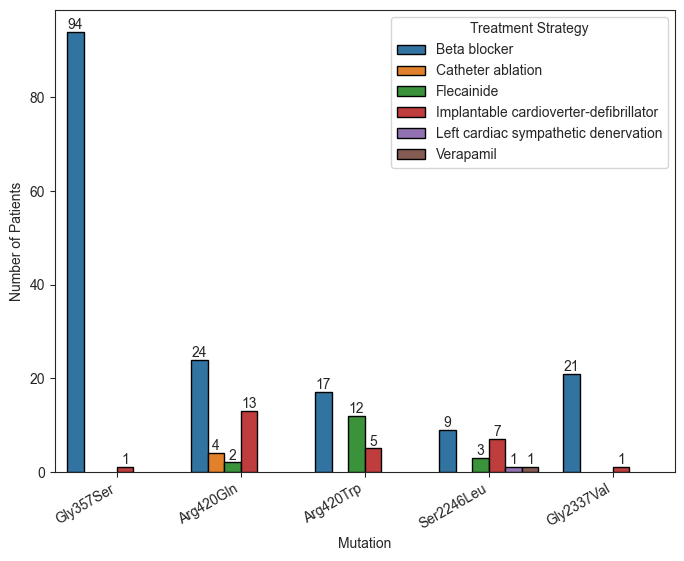

In [355]:
# grouped bar chart
plt.figure(figsize=(8, 6))

ax = sns.barplot(data=mutation_strategies, x="p_posedit_str", y="num_patients",
                 hue="treatment_name", edgecolor="black",
                 order=order_mutations["p_posedit_str"])

# add data labels
for bar in ax.patches:

    if bar.get_height() == 0:
        continue

    # Use ax.text() to add text over the bars
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            f'{bar.get_height():.0f}',
            ha='center', va='bottom')

plt.xticks(rotation=30, ha="right")
plt.xlabel("Mutation")
plt.ylabel("Number of Patients")
legend = plt.legend(title="Treatment Strategy", loc="upper right")

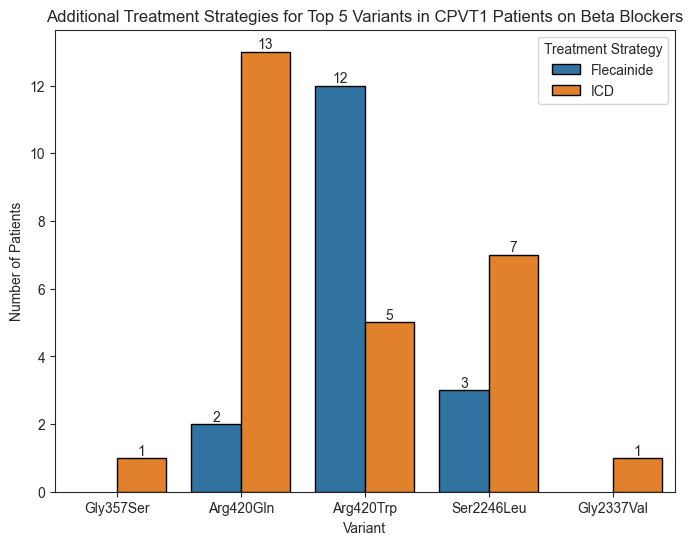

In [356]:
# grouped bar chart
plt.figure(figsize=(8, 6))

# filter to only ICD and Flecanide since they are the most common
treatment_groups = mutation_strategies[
    mutation_strategies["treatment_name"].isin(
        ["Implantable cardioverter-defibrillator", "Flecainide", ])
].copy()
treatment_groups["treatment_name"] = treatment_groups["treatment_name"].apply(
    lambda x: "ICD" if x == "Implantable cardioverter-defibrillator" else x)

ax = sns.barplot(data=treatment_groups, x="p_posedit_str", y="num_patients",
                 hue="treatment_name", edgecolor="black",
                 order=order_mutations["p_posedit_str"])

plt.xlabel("Variant")
plt.ylabel("Number of Patients")
plt.title(
    "Additional Treatment Strategies for Top 5 Variants in CPVT1 Patients on Beta Blockers")
plt.legend(title="Treatment Strategy", loc="upper right")

# add data labels
for bar in ax.patches:

    if bar.get_height() == 0:
        continue

    # Use ax.text() to add text over the bars
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            f'{bar.get_height():.0f}',
            ha='center', va='bottom')

for fmt in ["png", "pdf", "svg"]:
    plt.savefig(
        os.path.join(figures_dir,
                     'additional_treatment_strategies_cpvt1.' + fmt), dpi=300)

plt.show()



In [316]:
from sqlalchemy import text


def make_stmt(treatment_name, num_top_treatments=10):
    stmt = text(f"""
    SELECT sv.p_posedit_str, treatment_name, COUNT(tr.patient_id) AS num_patients
FROM treatment_record tr
JOIN treatment t
ON tr.treatment_id = t.treatment_id
JOIN individual_variant iv
ON tr.patient_id = iv.individual_id
JOIN variant v
ON iv.variant_id = v.variant_id
JOIN sequence_variant sv
ON sv.sequence_variant_id = v.sequence_variant_id
WHERE 1 = 1 
AND tr.patient_id IN (
-- ONLY CPVT1 patients
    SELECT individual_id
    FROM cpvt_patients_v
) 
AND tr.patient_id IN (
-- ONLY PATIENTS WHO ARE TAKING BETA BLOCKERS
    SELECT tr.patient_id
    FROM treatment_record tr
    JOIN treatment t
    ON tr.treatment_id = t.treatment_id
    WHERE t.treatment_name = 'Beta blocker'
    AND tr.treatment_taken = TRUE
)
AND tr.treatment_taken = TRUE
AND t.treatment_name = :treatment_name
GROUP BY sv.p_posedit_str, treatment_name
ORDER BY num_patients DESC
LIMIT :num_top_treatments
""")
    stmt = stmt.bindparams(treatment_name=treatment_name,
                           num_top_treatments=num_top_treatments)
    return stmt


# print out the top 10 variants by num patients using Flecanide then ICD
top_flecainide = pd.read_sql(make_stmt("Flecainide", 25), engine)
top_flecainide.head()

,p_posedit_str,treatment_name,num_patients
0,(Arg420Trp),Flecainide,12
1,(Met3978Ile),Flecainide,9
2,(Ser4124Gly),Flecainide,7
3,(Cys2277Arg),Flecainide,6
4,(Glu4187Gln),Flecainide,4


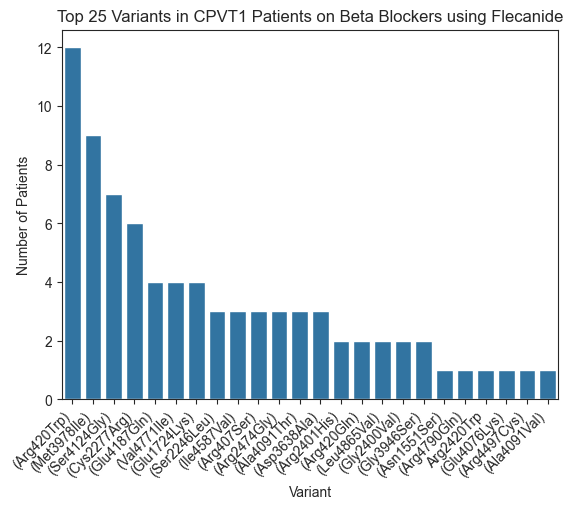

In [322]:
sns.barplot(top_flecainide, x="p_posedit_str", y="num_patients", )
plt.xticks(rotation=45, ha="right")
plt.title("Top 25 Variants in CPVT1 Patients on Beta Blockers using Flecanide")

plt.xlabel("Variant")
plt.ylabel("Number of Patients")

plt.show()

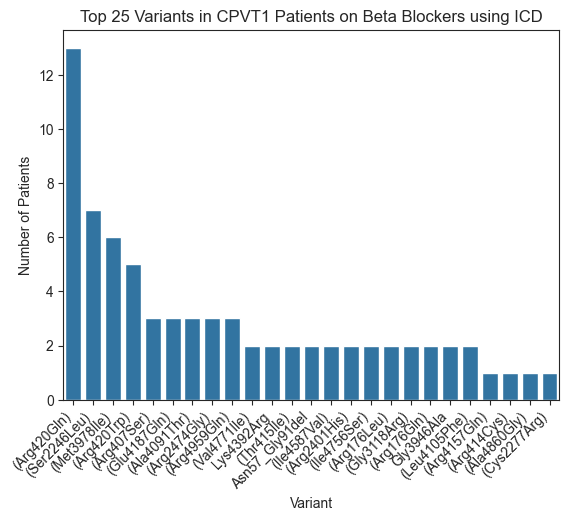

In [321]:
top_icd = pd.read_sql(make_stmt("Implantable cardioverter-defibrillator", 25),
                      engine)

sns.barplot(top_icd, x="p_posedit_str", y="num_patients", )
plt.xticks(rotation=45, ha="right")
plt.title("Top 25 Variants in CPVT1 Patients on Beta Blockers using ICD")

plt.xlabel("Variant")
plt.ylabel("Number of Patients")

plt.show()

In [300]:
# print out for Gly2337Ser
mutation_strategies[mutation_strategies["p_posedit_str"] == "Gly357Ser"]

,p_posedit_str,treatment_name,num_patients,treatment_group
10,Gly357Ser,Implantable cardioverter-defibrillator,1,Implantable cardioverter-defibrillator


In [301]:
treatment_groups

,p_posedit_str,treatment_group,treatment_name,num_patients
1,Arg420Gln,ICD,Implantable cardioverter-defibrillator,13
4,Arg420Trp,Poly-pharmaceutical,Flecainide,12
7,Ser2246Leu,ICD,Implantable cardioverter-defibrillator,7
3,Arg420Trp,ICD,Implantable cardioverter-defibrillator,5
9,Ser2246Leu,Poly-pharmaceutical,FlecainideVerapamil,4
2,Arg420Gln,Poly-pharmaceutical,Flecainide,2
5,Gly2337Val,ICD,Implantable cardioverter-defibrillator,1
6,Gly357Ser,ICD,Implantable cardioverter-defibrillator,1


In [302]:
# fisher test between each mutation 
from scipy.stats import fisher_exact
from itertools import combinations

mutations = treatment_groups["p_posedit_str"].unique()

for mut1, mut2 in combinations(mutations, 2):
    df_strat = treatment_groups[
        (treatment_groups["p_posedit_str"].isin([mut1, mut2]))
    ]

    # if there is only one treatment group, then skip
    if df_strat["treatment_group"].nunique() != 2:
        continue

    contingency_table = df_strat.pivot(
        index="p_posedit_str", columns="treatment_group",
        values="num_patients").fillna(0)



In [303]:
contingency_table

treatment_group,ICD,Poly-pharmaceutical
p_posedit_str,,
Gly357Ser,1.0,0.0
Ser2246Leu,7.0,4.0


In [304]:
treatment_groups["treatment_group"].unique()

array(['ICD', 'Poly-pharmaceutical'], dtype=object)

In [371]:
from sqlalchemy import Engine


def make_stmt_fisher(treatment: str, num_top_variants: int):
    stmt = text("""
SELECT sv.p_posedit_str, treatment_name, COUNT(tr.patient_id) AS num_patients
FROM treatment_record tr
JOIN treatment t
ON tr.treatment_id = t.treatment_id
JOIN individual_variant iv
ON tr.patient_id = iv.individual_id
JOIN variant v
ON iv.variant_id = v.variant_id
JOIN sequence_variant sv
ON sv.sequence_variant_id = v.sequence_variant_id
WHERE 1 = 1 
AND tr.patient_id IN (
-- ONLY CPVT1 patients
    SELECT individual_id
    FROM cpvt_patients_v
) 
AND tr.patient_id IN (
-- ONLY PATIENTS WHO ARE TAKING BETA BLOCKERS
    SELECT tr.patient_id
    FROM treatment_record tr
    JOIN treatment t
    ON tr.treatment_id = t.treatment_id
    WHERE t.treatment_name = 'Beta blocker'
    AND tr.treatment_taken = TRUE
)
AND tr.patient_id NOT IN (
-- Exclude patients taking any other treatment than the one specified + beta blockers
    SELECT tr.patient_id
    FROM treatment_record tr
    JOIN treatment t
    ON tr.treatment_id = t.treatment_id
    WHERE t.treatment_name NOT IN (:treatment_name, 'Beta blocker')
    AND tr.treatment_taken = TRUE
)
AND tr.patient_id IN (
-- ONLY take patients with the top 5 variants by number of individuals
    SELECT iv.individual_id
    FROM individual_variant iv
    WHERE v.variant_id IN (
        SELECT v2.variant_id 
        FROM variant_num_individuals_v v2 
        ORDER BY v2.num_individuals DESC 
        LIMIT :num_top_variants
    )
)
AND tr.treatment_taken = TRUE
GROUP BY sv.p_posedit_str, treatment_name
ORDER BY sv.p_posedit_str, treatment_name
                           """)
    stmt = stmt.bindparams(treatment_name=treatment,
                           num_top_variants=num_top_variants)

    return stmt


def create_fisher_table(
        treatment: str,
        num_top_variants: int,
        eng: Engine,
):
    df_fisher = pd.read_sql(make_stmt_fisher(treatment, num_top_variants), eng)

    df_fisher["treatment_name"] = df_fisher["treatment_name"].apply(
        lambda
            x: "Total" if x == "Beta blocker" else f"{treatment} + Beta Blocker")
    df_fisher = df_fisher.pivot(
        index="p_posedit_str", columns="treatment_name",
        values="num_patients").fillna(0)
    df_fisher["Beta Blocker Only"] = (df_fisher["Total"] -
                                      df_fisher[
                                          f"{treatment} + Beta Blocker"])

    # rearrange
    df_fisher = df_fisher[
        [f"{treatment} + Beta Blocker", "Beta Blocker Only", "Total"]]

    df_fisher = df_fisher.astype(int)
    df_fisher.reset_index(inplace=True)
    # drop treatment name
    df_fisher.columns.name = None
    return df_fisher


fisher_flecainide = create_fisher_table("Flecainide", 5, engine)
fisher_flecainide

,p_posedit_str,Flecainide + Beta Blocker,Beta Blocker Only,Total
0,(Arg420Gln),0,10,10
1,(Arg420Trp),9,3,12
2,(Gly357Ser),0,93,93
3,(Ser2246Leu),1,1,2
4,Gly2337Val,0,20,20


In [372]:
fisher_icd = create_fisher_table("Implantable cardioverter-defibrillator", 5,
                                 engine)
fisher_icd

,p_posedit_str,Implantable cardioverter-defibrillator + Beta Blocker,Beta Blocker Only,Total
0,(Arg420Gln),9,10,19
1,(Arg420Trp),2,3,5
2,(Gly357Ser),1,93,94
3,(Ser2246Leu),4,1,5
4,Gly2337Val,1,20,21


In [403]:
beta_blocker_eff = pd.read_sql("""
SELECT sv.p_posedit_str, 
    tr.effective AS Beta_Blocker_Effective,
    COUNT(tr.patient_id) AS num_patients
FROM treatment_record tr
JOIN treatment t
ON tr.treatment_id = t.treatment_id
JOIN individual_variant iv
ON tr.patient_id = iv.individual_id
JOIN variant v
ON iv.variant_id = v.variant_id
JOIN sequence_variant sv
ON sv.sequence_variant_id = v.sequence_variant_id
WHERE tr.patient_id IN (
    SELECT individual_id
    FROM cpvt_patients_v
)
AND sv.p_posedit_str IN (
-- Only include variants where there will be at least 5 patients TOTAL (effective and ineffective)
    SELECT sv2.p_posedit_str
    FROM treatment_record tr2
    JOIN treatment t2
    ON tr2.treatment_id = t2.treatment_id
    JOIN individual_variant iv2
    ON tr2.patient_id = iv2.individual_id
    JOIN variant v2
    ON iv2.variant_id = v2.variant_id
    JOIN sequence_variant sv2
    ON sv2.sequence_variant_id = v2.sequence_variant_id
    WHERE tr2.patient_id IN (
        SELECT individual_id
        FROM cpvt_patients_v
    )
    AND tr2.treatment_taken = TRUE
    AND t2.treatment_name = 'Beta blocker'
    AND tr2.effective IS NOT NULL
    GROUP BY sv2.p_posedit_str
    HAVING COUNT(tr2.patient_id) >= 5
)
AND tr.treatment_taken = TRUE
AND t.treatment_name = 'Beta blocker'
AND tr.effective IS NOT NULL
GROUP BY sv.p_posedit_str, tr.effective
ORDER BY sv.p_posedit_str, tr.effective
""", engine)
beta_blocker_eff

,p_posedit_str,beta_blocker_effective,num_patients
0,(Arg2401His),False,4
1,(Arg2401His),True,2
2,(Arg420Gln),False,8
3,(Arg420Gln),True,10
4,(Arg420Trp),False,12
5,(Arg420Trp),True,5
6,(Cys2277Arg),False,6
7,(Cys2277Arg),True,2
8,(Glu1724Lys),False,3
9,(Glu1724Lys),True,2


In [410]:
bb_percents = beta_blocker_eff.pivot(
    index="p_posedit_str", columns="beta_blocker_effective",
    values="num_patients").fillna(0)
# bb_percents["% Effective"] = (100 * bb_percents["True"]) / (bb_percents["True"] + bb_percents["False"])
bb_percents.astype(int)
bb_percents["% Effective"] = 100 * bb_percents[True] / (
        bb_percents[True] + bb_percents[False])
bb_percents.reset_index(inplace=True)
bb_percents.columns.name = None
bb_percents.sort_values("% Effective", ascending=False, inplace=True)
bb_percents

,p_posedit_str,False,True,% Effective
9,Gly2337Val,1.0,10.0,90.909091
1,(Arg420Gln),8.0,10.0,55.555556
6,(Met3978Ile),7.0,7.0,50.000000
5,(Gly3946Ser),3.0,3.0,50.000000
4,(Glu1724Lys),3.0,2.0,40.000000
7,(Ser2246Leu),5.0,3.0,37.500000
0,(Arg2401His),4.0,2.0,33.333333
2,(Arg420Trp),12.0,5.0,29.411765
3,(Cys2277Arg),6.0,2.0,25.000000
8,(Ser4124Gly),6.0,0.0,0.000000


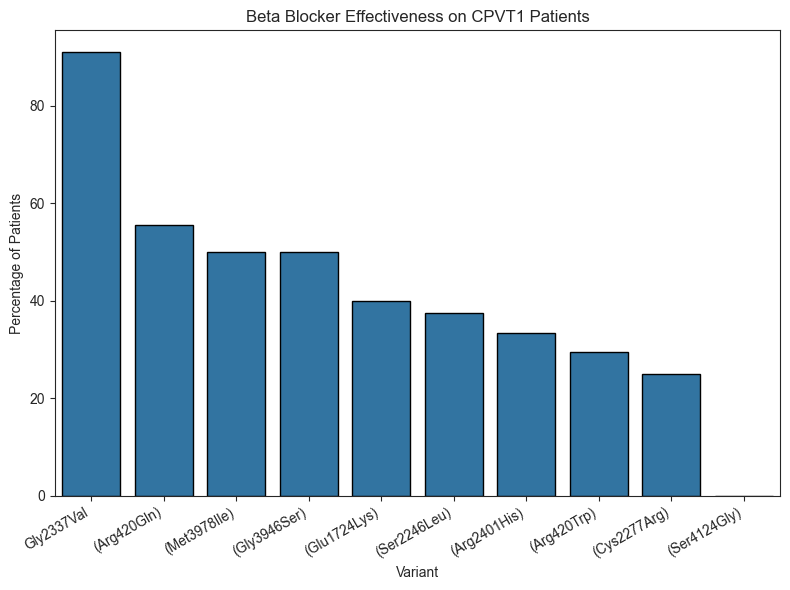

In [414]:
plt.figure(figsize=(8, 6))

# order by the percentage of patients that are effective
ax = sns.barplot(data=bb_percents, x="p_posedit_str", y="% Effective",
                 edgecolor="black")

plt.xticks(rotation=30, ha="right")
plt.xlabel("Variant")
plt.ylabel("Percentage of Patients")
plt.title("Beta Blocker Effectiveness on CPVT1 Patients")

plt.tight_layout()
plt.show()

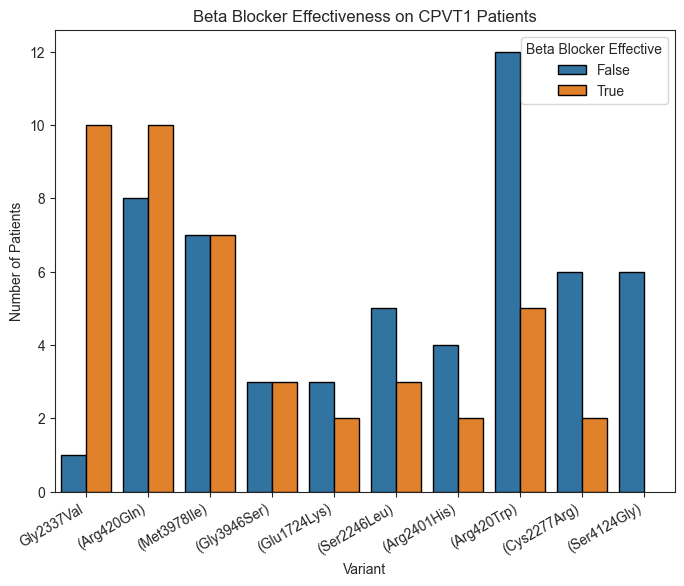

In [413]:
plt.figure(figsize=(8, 6))

# order by the percentage of patients that are effective
ax = sns.barplot(data=beta_blocker_eff, x="p_posedit_str", y="num_patients",
                 hue="beta_blocker_effective", edgecolor="black",
                 order=bb_percents["p_posedit_str"])

plt.xticks(rotation=30, ha="right")
plt.xlabel("Variant")
plt.ylabel("Number of Patients")
plt.title("Beta Blocker Effectiveness on CPVT1 Patients")

plt.legend(title="Beta Blocker Effective", loc="upper right")


In [401]:
beta_blocker_eff.groupby("p_posedit_str").apply(lambda x: 100 * x / x.sum())

beta_blocker_effective  num_patients
p_posedit_str                                         
(Arg2401His)  0                      0.0     66.666667
              1                    100.0     33.333333
(Arg420Gln)   2                      0.0     44.444444
              3                    100.0     55.555556
(Arg420Trp)   4                      0.0     70.588235
              5                    100.0     29.411765
(Cys2277Arg)  6                      0.0     75.000000
              7                    100.0     25.000000
(Glu1724Lys)  8                      0.0     60.000000
              9                    100.0     40.000000
(Gly3946Ser)  12                     0.0     50.000000
              13                   100.0     50.000000
(Met3978Ile)  14                     0.0     50.000000
              15                   100.0     50.000000
(Ser2246Leu)  16                     0.0     62.500000
              17                   100.0     37.500000
(Ser4124Gly)  18                     NaN    100.000000
Gly2337Val    10                     0.0      9.090909
              11                   100.0     90.909091